In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
sys.path.append('..\model')
from BathPlateModel import BathPlateModel

model=BathPlateModel(holes=0,outerBox="sphere", boxx=0.2, div_thick=1)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)


Bath Plate Model    holes: 0    Thickness: 0.00635
boxx=  0.2  boxy=  0.28  boxz=  0.4
div_thick=  1
name: conductor   mass: 4.191e-05   center: (-9.19197e-20, -2.9053e-19, 0)
name: air   mass: 0.0002321300000000001   center: (0, -1.28009e-19, -6.88219e-20)
name: reduced   mass: 0.033236281638291114   center: (-1.60174e-17, -1.51188e-17, 1.54601e-19)
conductive_region: conductor
Conductor boundary: conductorBND
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced': 1.2566370614359173e-06, 'hole1': 1.2566370614359173e-06, 'hole2': 1.2566370614359173e-06, 'default': 1.2566370614359173e-06}
class HolePot: num= 0  holes
class MeasureFace: num= 0  faces


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:
import math
import sys
sys.path.append('C:\EMSolution\EMSolPy3\python\include')
from MatrixSolver import MatrixSolver as solver 

jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=True
feorder=3

Mu=model.Mu
field=UNIF(0,0,0.01,0)
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

mu=4.e-7*math.pi
normal = specialcf.normal(mesh.dim)

fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega) 
if Dirichlet==False:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
fesTOmega=fesT*fesOmega    
(T,omega),(W,psi) = fesTOmega.TnT()
a= BilinearForm(fesTOmega)
a +=Mu*(grad(omega)*grad(psi))*dx(air_region)
a +=Mu*((T+grad(omega))*(W+grad(psi)))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()

gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega=gfTOmega.components
if Dirichlet==False:
    b=Bfield(field)
    f = LinearForm(fesTOmega)
    f += (normal*b)*psi*ds(reduced_boundary)
    with TaskManager():
        f.Assemble()
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0., complex=jomega)

else:  
    O=Ofield(field)
    gfOmega.Set(O, BND, mesh.Boundaries(reduced_boundary))
    """
    r=-a.mat*gfTOmega.vec
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, r.Evaluate(), tol=1.e-16, max_iter=200, accel_factor=1.1, complex=jomega)

    """
    f = LinearForm(fesTOmega)
    f +=-Mu*grad(gfOmega)*grad(psi)*dx
    with TaskManager():
        f.Assemble()  
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega)
    
 
#Draw (gfOmega*mu, mesh, order=3, min=0., max=1.0, deformation=False)       
Bfield=Mu*(gfT+grad(gfOmega))
#Draw (Bfield, mesh, order=3, min=0.5, max=1.5, deformation=False)
Jfield=curl(gfT)

mip = mesh(0,0,0)
print(Bfield(mip))


enter iccg_solve
Dof= 2446    matrix size= 24926.0
shift parameter= 1.0
minimum residual= 3.625026464823503e-17  at iteraions:  53
結果のノルム: 1.115375512224493e-15
power=  (2.456905047555644+0.006604093027921182j)
((3.6140760182524286e-05+4.850049642344134e-05j), (-8.223513483135927e-06-1.2590822439331795e-05j), (0.006374417330831774-0.00535749165888128j))


In [3]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region, mesh))
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  1.037368507007061


In [4]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
#    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

feOrder=1
Dirichlet=True

Jz real [0, 0.922e6]
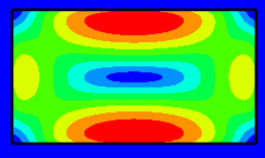
Jz imag [0, 2.44e6] 
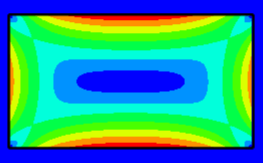

 Average Joule loss=  1.0895938658030582
